In [ ]:
pip install contractions transformers torch tqdm

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, hamming_loss

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import contractions

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/A/A_forSkripsiii/train.csv')

In [ ]:
text_column = 'comment_text'
label_columns = data.columns.difference([text_column]).tolist()
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def preprocess_text(text):
    text = text.lower()  # Convert all characters to lowercase
    text = re.sub(r'http\S+|www\S+', 'url', text)  # Replace hyperlinks with "url"
    text = re.sub(r'@\w+', 'username', text)  # Replace usernames with "username"
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', 'number', text)  # Replace numbers with "number"
    text = contractions.fix(text)  # Normalize contractions
    return text

data['comment_text'] = data['comment_text'].apply(preprocess_text)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Update the function to ensure input tensors are moved to the right device
def get_bert_embeddings(text):
    # Tokenize and encode text with BERT tokenizer
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=200).to(device)

    # Pass the tokenized inputs through the BERT model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings from the last hidden state
    last_hidden_state = outputs.last_hidden_state

    # For sentence-level embedding, average the token embeddings
    sentence_embedding = last_hidden_state.mean(dim=1)
    return sentence_embedding

In [ ]:
# Enable tqdm for pandas apply
tqdm.pandas()

# Get BERT embeddings for all text in the dataset
embeddings = data['comment_text'].progress_apply(get_bert_embeddings)

100%|██████████| 159571/159571 [26:58<00:00, 98.61it/s]


In [ ]:
# Convert embeddings to a NumPy array
embedding_array = np.array([emb.detach().cpu().numpy().flatten() for emb in embeddings])

# Save embeddings to Google Drive
embeddings_path = '/content/drive/MyDrive/A/A_forSkripsiii/BERTembeddings200.npy'
np.save(embeddings_path, embedding_array)

print(f"Embeddings saved to {embeddings_path}")

Embeddings saved to /content/drive/MyDrive/A/A_forSkripsiii/BERTembeddings200.npy


# TRAINING

In [ ]:
embeddings_path = '/content/drive/MyDrive/A/A_forSkripsiii/BERTembeddings200.npy'
model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/BertBigru'
os.makedirs(model_dir, exist_ok=True)

In [ ]:
embedding_array = np.load(embeddings_path)

In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/A/A_forSkripsiii/train.csv')

In [ ]:
# Prepare labels (multilabel classification)
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Split to training and validation
X_train, X_val, y_train, y_val = train_test_split(embedding_array, labels, test_size=0.3, random_state=42)

# Reshape embeddings to be (samples, timesteps, features) for GRU input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Build the Bi-GRU model for multilabel classification
model = Sequential([
    Input(shape=(X_train.shape[1], 1)), #BERT Embeddings
    Bidirectional(GRU(64, return_sequences=False)), # BiGRU
    Dropout(0.2),
    Dense(6, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# ModelCheckpoint callback to save after each epoch
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'bert_bgru_epoch_{epoch:02d}.h5'),
    save_weights_only=False,
    save_best_only=False
)

Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8087 - loss: 0.1920

873/873 ━━━━━━━━━━━━━━━━━━━━ 494s 562ms/step - accuracy: 0.8088 - loss: 0.1919 - val_accuracy: 0.9939 - val_loss: 0.0993
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9906 - loss: 0.0924

873/873 ━━━━━━━━━━━━━━━━━━━━ 491s 563ms/step - accuracy: 0.9906 - loss: 0.0924 - val_accuracy: 0.9940 - val_loss: 0.0829
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9924 - loss: 0.0811

873/873 ━━━━━━━━━━━━━━━━━━━━ 492s 563ms/step - accuracy: 0.9924 - loss: 0.0811 - val_accuracy: 0.9940 - val_loss: 0.0789
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9937 - loss: 0.0792

873/873 ━━━━━━━━━━━━━━━━━━━━ 492s 563ms/step - accuracy: 0.9937 - loss: 0.0792 - val_accuracy: 0.9939 - val_loss: 0.0767
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9932 - loss: 0.0759

873/873 ━━━━━━━━━━━━━━━━━━━━ 492s 563ms/step - accuracy: 0.9932 - loss: 0.0759 - val_accuracy: 0.9940 - val_loss: 0.0750
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9940 - loss: 0.0740

873/873 ━━━━━━━━━━━━━━━━━━━━ 492s 563ms/step - accuracy: 0.9940 - loss: 0.0740 - val_accuracy: 0.9940 - val_loss: 0.0723
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9937 - loss: 0.0723

873/873 ━━━━━━━━━━━━━━━━━━━━ 492s 563ms/step - accuracy: 0.9937 - loss: 0.0723 - val_accuracy: 0.9940 - val_loss: 0.0703
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9942 - loss: 0.0706

873/873 ━━━━━━━━━━━━━━━━━━━━ 492s 563ms/step - accuracy: 0.9942 - loss: 0.0706 - val_accuracy: 0.9940 - val_loss: 0.0689
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9939 - loss: 0.0685

873/873 ━━━━━━━━━━━━━━━━━━━━ 492s 563ms/step - accuracy: 0.9939 - loss: 0.0685 - val_accuracy: 0.9940 - val_loss: 0.0689
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9942 - loss: 0.0677

873/873 ━━━━━━━━━━━━━━━━━━━━ 492s 564ms/step - accuracy: 0.9942 - loss: 0.0677 - val_accuracy: 0.9940 - val_loss: 0.0692


In [ ]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[checkpoint_cb]
)

# EVALUATION

In [ ]:
# Define paths
model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/BertBigru'
embeddings_path = '/content/drive/MyDrive/A/A_forSkripsiii/BERTembeddings200.npy'
data_path = '/content/drive/MyDrive/A/A_forSkripsiii/train.csv'

# Load dataset
data = pd.read_csv(data_path)

# Define labels
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = data[label_columns].values

# Load BERT embeddings
embedding_array = np.load(embeddings_path)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(embedding_array, labels, test_size=0.3, random_state=42)

# Reshape embeddings to (samples, timesteps, features)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Initialize results list
results = []


In [ ]:
# Loop through model files and evaluate
for model_file in os.listdir(model_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(model_dir, model_file)
        print(f"Evaluating model: {model_file}")

        # Load model
        model = load_model(model_path)

        # Predict
        y_pred_prob = model.predict(X_val, verbose=0)

        # Evaluate
        loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
        hamming = hamming_loss(np.round(y_pred_prob), y_val)
        logloss = log_loss(y_val, y_pred_prob)

        # Store metrics
        results.append({
            'Model': model_file,
            'Accuracy': accuracy,
            'Log Loss': logloss,
            'Hamming Loss': hamming
        })

# Results dataframe
results_df = pd.DataFrame(results)

Evaluating model: bert_bgru_epoch_01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: bert_bgru_epoch_02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: bert_bgru_epoch_03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: bert_bgru_epoch_04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: bert_bgru_epoch_05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: bert_bgru_epoch_06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: bert_bgru_epoch_07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: bert_bgru_epoch_08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: bert_bgru_epoch_09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: bert_bgru_epoch_10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
results_df

,Model,Accuracy,Log Loss,Hamming Loss
0,bert_bgru_epoch_01.h5,0.993879,0.370016,0.031675
1,bert_bgru_epoch_02.h5,0.994005,0.361563,0.027542
2,bert_bgru_epoch_03.h5,0.994026,0.291375,0.027142
3,bert_bgru_epoch_04.h5,0.993879,0.314450,0.026411
4,bert_bgru_epoch_05.h5,0.994026,0.268503,0.026070
5,bert_bgru_epoch_06.h5,0.994026,0.275631,0.025370
6,bert_bgru_epoch_07.h5,0.993984,0.291843,0.024882
7,bert_bgru_epoch_08.h5,0.994005,0.290581,0.024346
8,bert_bgru_epoch_09.h5,0.994047,0.302285,0.024332
9,bert_bgru_epoch_10.h5,0.993984,0.321304,0.024367


In [ ]:
def extract_model_info(name):
    match = re.search(r"epoch_(\d+)", name)
    if match:
        return int(match.group(1))
    return None

results_df['Epoch'] = results_df['Model'].apply(extract_model_info)

# Sort by Epoch
results_df_sorted = results_df.sort_values(by=['Epoch']).reset_index(drop=True)
print(results_df_sorted)


                   Model  Accuracy  Log Loss  Hamming Loss  Epoch
0  bert_bgru_epoch_01.h5  0.993879  0.370016      0.031675      1
1  bert_bgru_epoch_02.h5  0.994005  0.361563      0.027542      2
2  bert_bgru_epoch_03.h5  0.994026  0.291375      0.027142      3
3  bert_bgru_epoch_04.h5  0.993879  0.314450      0.026411      4
4  bert_bgru_epoch_05.h5  0.994026  0.268503      0.026070      5
5  bert_bgru_epoch_06.h5  0.994026  0.275631      0.025370      6
6  bert_bgru_epoch_07.h5  0.993984  0.291843      0.024882      7
7  bert_bgru_epoch_08.h5  0.994005  0.290581      0.024346      8
8  bert_bgru_epoch_09.h5  0.994047  0.302285      0.024332      9
9  bert_bgru_epoch_10.h5  0.993984  0.321304      0.024367     10


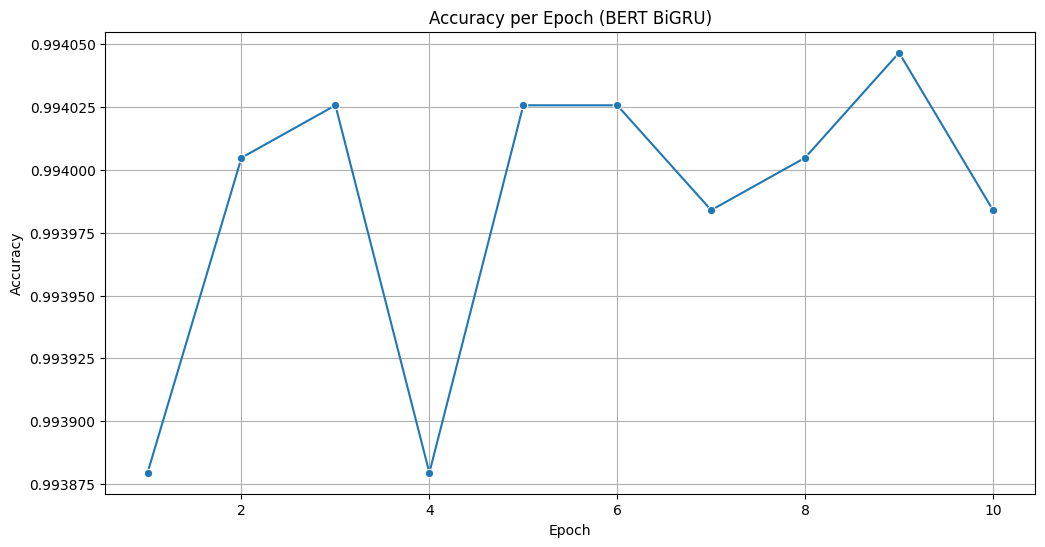

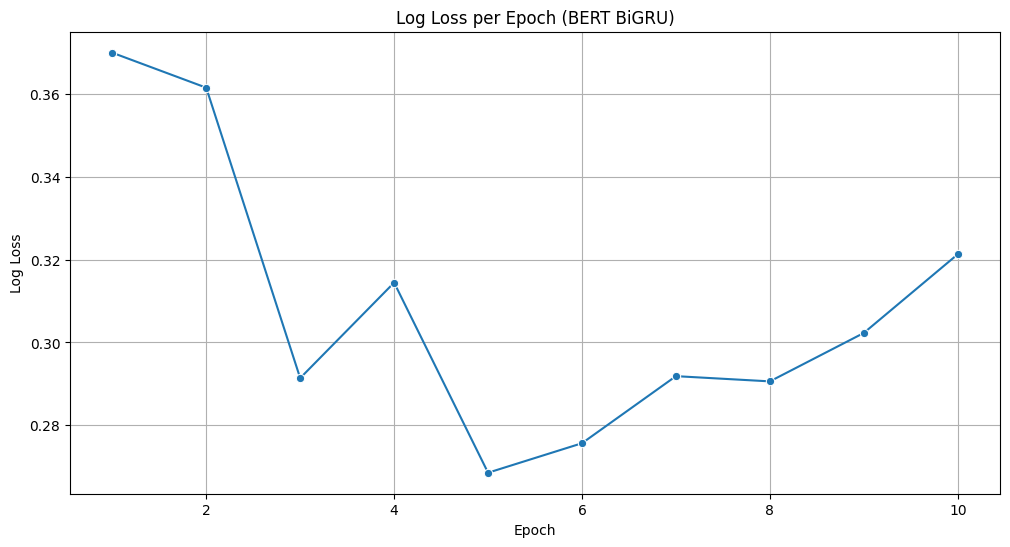

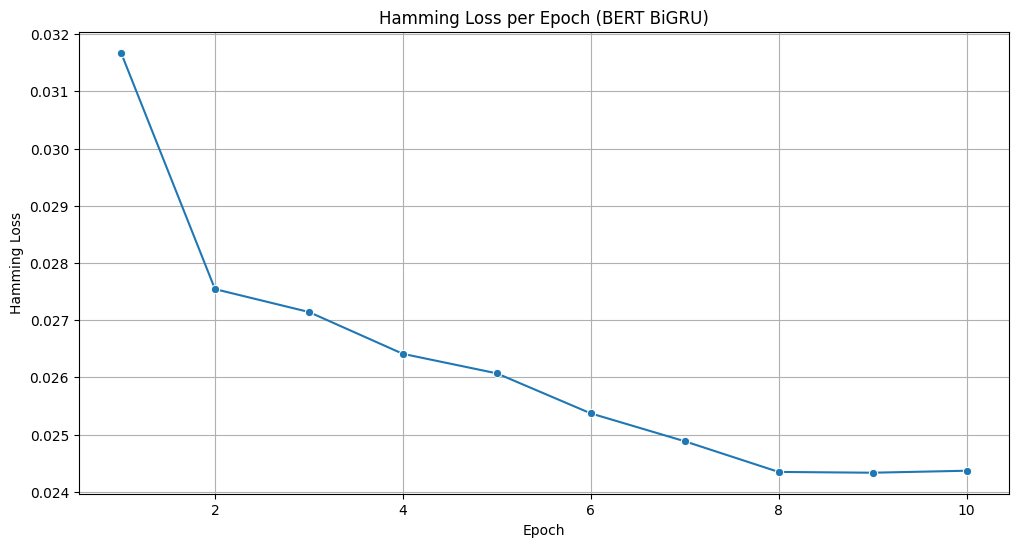

In [ ]:
# Plot Accuracy per Epoch
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df_sorted, x='Epoch', y='Accuracy', marker='o')
plt.title('Accuracy per Epoch (BERT BiGRU)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot Log Loss per Epoch
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df_sorted, x='Epoch', y='Log Loss', marker='o')
plt.title('Log Loss per Epoch (BERT BiGRU)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.grid(True)
plt.show()

# Plot Hamming Loss per Epoch
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df_sorted, x='Epoch', y='Hamming Loss', marker='o')
plt.title('Hamming Loss per Epoch (BERT BiGRU)')
plt.xlabel('Epoch')
plt.ylabel('Hamming Loss')
plt.grid(True)
plt.show()